In [14]:
import pandas as pd
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split
import sys
sys.path.append('../')
import function
from sklearn.preprocessing import MinMaxScaler

In [15]:
df_origin = pd.read_excel('../VisitorEntrancesV3.xlsx')

In [16]:
df = df_origin[df_origin.Site_Name=='The Masada']
df = function.remove_unique_one(df)
df = df.drop(df.filter(regex='Season').columns, axis=1)
df = df.drop(df.filter(regex='Exceeded').columns, axis=1)
df = df.drop(df.filter(regex='isHeatwave').columns, axis=1)
df = df.replace({True:1,False:0})

In [17]:
# dfWithoutLastYearVisits = df.dropna().drop('last_year_visitors',axis=1)
dfWithoutLastYearVisits = df.drop('last_year_visitors',axis=1).dropna()
dfLastYearVisits = df.dropna()

In [18]:
print(dfLastYearVisits.shape)
print(dfWithoutLastYearVisits.shape)

(1011, 7)
(1387, 6)


In [19]:
from sklearn.metrics import mean_absolute_error
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from IPython.display import clear_output
from keras.regularizers import l2

In [20]:
dfWithoutLastYearVisits.sort_values('Date')
X = dfWithoutLastYearVisits.drop(['Israelis_Count'],axis=1)
y = dfWithoutLastYearVisits[['Date','Israelis_Count']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size = 0.2)

X_train_scaler = MinMaxScaler()
X_test_scaler = MinMaxScaler()

X_train_scaled = X_train_scaler.fit_transform(X_train.drop('Date',axis=1))
X_test_scaled = X_test_scaler.fit_transform(X_test.drop('Date',axis=1))
 
X_train_scaled


X_train_date = X_train.Date
y_train_date = y_train.Date
X_test_date = X_test.Date
y_test_date = y_test.Date

y_train.drop('Date',axis=1,inplace=True)
y_test.drop('Date',axis=1,inplace=True)

In [21]:
# create NN model
model = Sequential()
model.add(Dense(X_train_scaled.shape[1], input_dim=X_train_scaled.shape[1],activation='relu',activity_regularizer=l2(0.01)))
model.add(Dense(516,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(516,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.3))

model.add(Dense(64,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu',activity_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(1))
 

In [22]:
# Compiling the model
model.compile(metrics=['mae','accuracy'], optimizer='adam', loss = 'mean_squared_error')
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1 )
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=0 )
mcp = ModelCheckpoint(filepath='weightsTheMasadaWithoutLastYear.h5', monitor='val_loss', verbose=1 , save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train_scaled, y_train, shuffle=True, epochs=10000,callbacks=[es, rlr, mcp, tb],validation_split=0.2,batch_size=1)
clear_output(True)


Epoch 1/10000
876/887 [============================>.] - ETA: 0s - loss: 952240.5000 - mae: 752.7948 - accuracy: 0.0000e+00
Epoch 1: val_loss improved from inf to 747687.62500, saving model to weightsTheMasadaWithoutLastYear.h5
887/887 [==============================] - 4s 4ms/step - loss: 948946.5625 - mae: 751.1230 - accuracy: 0.0000e+00 - val_loss: 747687.6250 - val_mae: 730.3221 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/10000
871/887 [============================>.] - ETA: 0s - loss: 684603.6875 - mae: 654.2401 - accuracy: 0.0000e+00
Epoch 2: val_loss improved from 747687.62500 to 704232.62500, saving model to weightsTheMasadaWithoutLastYear.h5
887/887 [==============================] - 3s 4ms/step - loss: 684885.3125 - mae: 654.1268 - accuracy: 0.0000e+00 - val_loss: 704232.6250 - val_mae: 706.6630 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/10000
877/887 [============================>.] - ETA: 0s - loss: 663827.0000 - mae: 635.5431 - accuracy: 0.0000e+00
Epoch 3: val_lo

In [23]:
model.load_weights('weightsTheMasadaWithoutLastYear.h5')

35/35 [==============================] - 0s 3ms/step

mae 537.541364884785
rmse 677.2450208181793
std 759.2640653234772


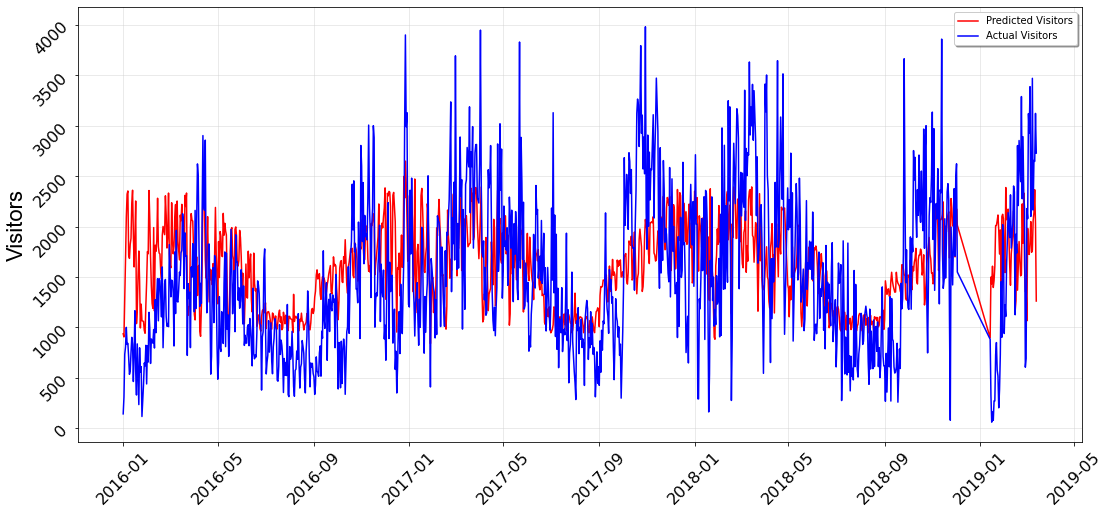

,Prediction,Actual
Date,,
2016-01-01,937.291443,143
2016-01-02,906.003845,309
2016-01-03,1268.421265,735
2016-01-04,1677.116943,809
2016-01-05,2091.846436,1001
2016-01-06,2322.394531,832
2016-01-07,2353.889404,842
2016-01-08,1715.164185,705
2016-01-09,1685.011475,535


In [24]:
prediction = model.predict(X_train_scaled)
prediction = prediction.reshape(len(X_train_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_train.values.T[0],
        },
    index=y_train_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

9/9 [==============================] - 0s 2ms/step

mae 603.4399266963383
rmse 763.8006901564993
std 856.4191308917395


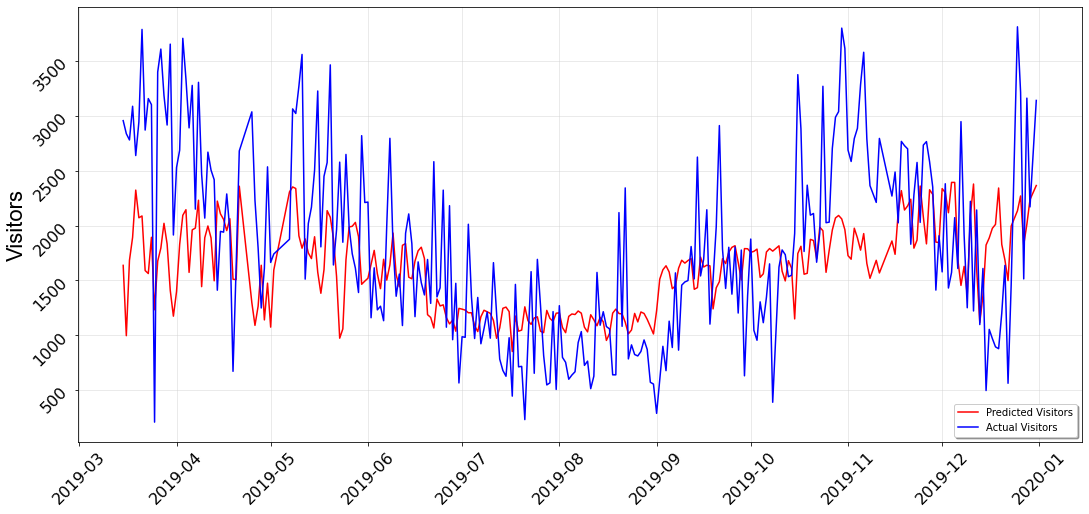

,Prediction,Actual
Date,,
2019-03-15,1637.432373,2956
2019-03-16,996.703247,2837
2019-03-17,1683.266357,2780
2019-03-18,1892.541748,3087
2019-03-19,2323.156250,2638
2019-03-20,2070.931152,2944
2019-03-21,2087.505859,3787
2019-03-22,1590.100098,2870
2019-03-23,1563.009277,3157


In [25]:
prediction = model.predict(X_test_scaled)
prediction = prediction.reshape(len(X_test_scaled))
print('')
res = pd.DataFrame(
    data={
        'Prediction':prediction,
        'Actual': y_test.values.T[0],
        },
    index=y_test_date
)
print('mae', mean_absolute_error(res.Prediction, res.Actual))
print('rmse',function.get_rmse(res.Prediction, res.Actual))
print('std',np.std(res.Actual))

res.sort_index(inplace=True)
function.plot_line(res.Prediction, res.Actual)
# function.plot_residuals(res.Prediction, res.Actual)
res.head(10)

In [26]:
from lime_stability.stability import LimeTabularExplainerOvr

class_names=['Israelis_Count']

categorical_features = np.argwhere(
    np.array([len(set(X_train_scaled[:,x]))
    for x in range(X_train_scaled.shape[1])]) <= 2).flatten()

print(X_train_scaled.shape)
print(categorical_features.shape)
print(X_train_scaled.shape)

explainer = LimeTabularExplainerOvr(np.array(X_train_scaled),
 feature_names=X_train.drop('Date',axis=1).columns,
 class_names=class_names, 
 categorical_features=categorical_features, 
 verbose=True,
 mode='regression'
 )

i = np.random.randint(len(X_test_scaled))
print('index ', i, ':: Actual values = ', y_test.Israelis_Count.values[i])
print('index ', i, ':: Prediction values = ', prediction.tolist()[i])
exp = explainer.explain_instance((X_test_scaled[i]),model.predict,num_features=100)
exp.show_in_notebook(show_table=True)
function.outputLimeAsDf(exp)


(1109, 4)
(2,)
(1109, 4)
index  210 :: Actual values =  2368
index  210 :: Prediction values =  1565.068359375
157/157 [==============================] - 0s 3ms/step
Intercept 1399.9388227901168
Prediction_local [1751.12221441]
Right: 1565.0684


,0
Temperature,386.118317
is weekend,-250.166548
IsVacation,-222.511741
pm10,-7.280118


In [28]:
function.getLimeAvg(X_test_scaled=X_test_scaled,X_train_scaled=X_train_scaled,X_train=X_train,model=model)

(1109, 4)
(2,)
(1109, 4)
157/157 [==============================] - 1s 3ms/step
Intercept 1493.3260976065944
Prediction_local [1609.25258571]
Right: 1637.4324
157/157 [==============================] - 1s 3ms/step
Intercept 1488.4051784442422
Prediction_local [1569.94723636]
Right: 1637.4324
157/157 [==============================] - 1s 3ms/step
Intercept 1489.236412184397
Prediction_local [1596.36356784]
Right: 1637.4324
157/157 [==============================] - 1s 3ms/step
Intercept 1496.6964261895548
Prediction_local [1607.28142654]
Right: 1637.4324
157/157 [==============================] - 1s 4ms/step
Intercept 1510.9817644083785
Prediction_local [1576.62274646]
Right: 1637.4324
157/157 [==============================] - 1s 3ms/step
Intercept 1504.1652186476929
Prediction_local [1588.9307523]
Right: 1637.4324
157/157 [==============================] - 1s 4ms/step
Intercept 1506.7776021333734
Prediction_local [1576.36280797]
Right: 1637.4324
157/157 [==============================

,0
IsVacation,-198.367295
Temperature,25.071828
is weekend,-245.140752
IsHoliday,NaN
pm10,1.528189
